# **Predict Stroke**

- Import Library

In [52]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import skew
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

- Load Data

In [53]:
df = pd.read_csv('../dataset/housing.csv')

In [54]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Data Preprocessing

- Handling Missing & Duplicated Values

In [55]:
df.duplicated().sum()

np.int64(0)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [57]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [58]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [59]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [60]:
numeric = df.select_dtypes(include=['number']).columns
for i in numeric:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[i] < lower) | (df[i] > upper)]
    print(f"Kolom '{i}': {len(outliers)} outlier")

Kolom 'longitude': 0 outlier
Kolom 'latitude': 0 outlier
Kolom 'housing_median_age': 0 outlier
Kolom 'total_rooms': 1287 outlier
Kolom 'total_bedrooms': 1271 outlier
Kolom 'population': 1196 outlier
Kolom 'households': 1220 outlier
Kolom 'median_income': 681 outlier
Kolom 'median_house_value': 1071 outlier


In [61]:
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())

- Outliers Handling

In [62]:
df['median_house_value'].mean()

np.float64(206855.81690891474)

In [63]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [64]:

def outliersHandling(series):
  Q1 = df[series].quantile(0.25)
  Q3 = df[series].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df.loc[df[series] > upper_bound, series] = upper_bound
  df.loc[df[series] < lower_bound, series] = lower_bound
  return df


In [65]:
numeric = df.select_dtypes(include=['number']).columns

for i in numeric:
  df = outliersHandling(i)

for i in numeric:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[i] < lower) | (df[i] > upper)]
    print(f"Kolom '{i}': {len(outliers)} outlier")

Kolom 'longitude': 0 outlier
Kolom 'latitude': 0 outlier
Kolom 'housing_median_age': 0 outlier
Kolom 'total_rooms': 0 outlier
Kolom 'total_bedrooms': 0 outlier
Kolom 'population': 0 outlier
Kolom 'households': 0 outlier
Kolom 'median_income': 0 outlier
Kolom 'median_house_value': 0 outlier


- Feature Engineering

In [66]:
ohe = OneHotEncoder(sparse_output=False)
encoded_data = ohe.fit_transform(df[['ocean_proximity']])
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(['ocean_proximity']))
df = pd.concat([df.drop("ocean_proximity", axis=1), encoded_df],axis=1)

- Data Splitting

In [67]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelling & Evaluation

In [68]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
early = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early])

Epoch 1/50


d:\ML\ML-PredictNumerical\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 50799525888.0000 - mae: 194670.3125 - val_loss: 8458016768.0000 - val_mae: 69682.0391
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8080094720.0000 - mae: 68668.9062 - val_loss: 6027424768.0000 - val_mae: 57368.9414
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6241881088.0000 - mae: 58817.4531 - val_loss: 5239020032.0000 - val_mae: 52726.2539
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5415463424.0000 - mae: 54271.6445 - val_loss: 4795996160.0000 - val_mae: 50071.4219
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5285352448.0000 - mae: 53041.0234 - val_loss: 4545245696.0000 - val_mae: 48071.2109
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4877345280.0000 - mae: 50801.2969 - val_loss: 4383399936.0000 - val_mae: 47157.3359
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4828836864.0000 - mae: 50287.6719 - val_loss: 4283635200.0000 - val_mae: 46569.4453
E

In [69]:
val_mae = history.history['val_mae'][-1]
mae_percent = (val_mae / y_test.mean()) * 100
print(f"MAE sekitar {mae_percent:.2f}% dari rata-rata harga rumah.")

MAE sekitar 20.53% dari rata-rata harga rumah.


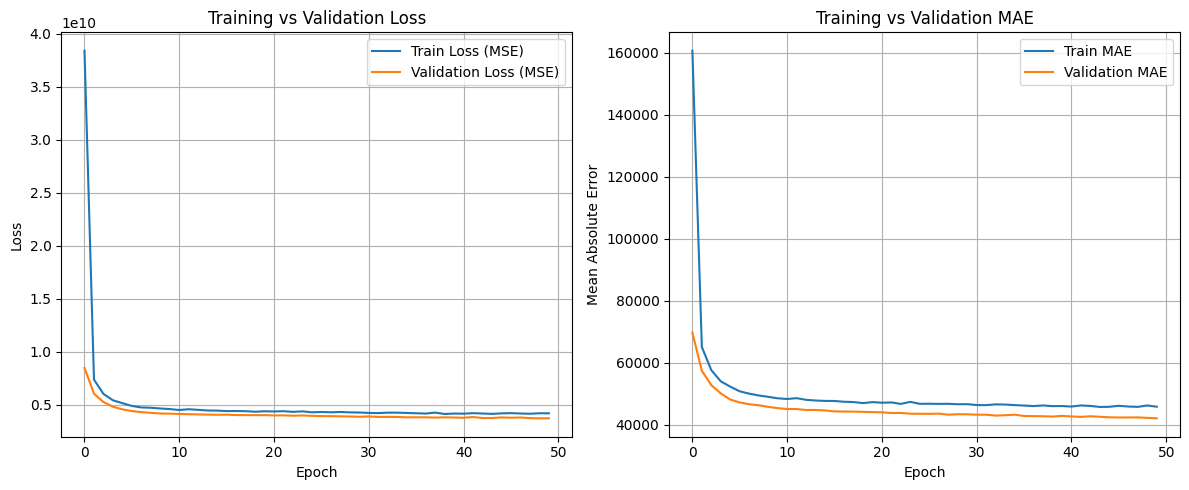

In [70]:
# Plot Loss (MSE)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Training vs Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [71]:
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Conv1D(32, kernel_size=2, activation='relu', padding='same'),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
early = EarlyStopping(patience=5, restore_best_weights=True)
history_cnn = cnn_model.fit(X_train_cnn, y_train, epochs=50, validation_data=(X_test_cnn, y_test), batch_size=32, verbose=1, callbacks=[early])


Epoch 1/50


d:\ML\ML-PredictNumerical\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


516/516 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 54614220800.0000 - mae: 203819.9062 - val_loss: 23315197952.0000 - val_mae: 111359.4062
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 19903131648.0000 - mae: 104296.8750 - val_loss: 16081180672.0000 - val_mae: 92485.9766
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 13945624576.0000 - mae: 91164.3125 - val_loss: 16635169792.0000 - val_mae: 84818.0391
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 12286201856.0000 - mae: 85340.0859 - val_loss: 16822900736.0000 - val_mae: 83318.5078
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 11773466624.0000 - mae: 83791.5469 - val_loss: 16392225792.0000 - val_mae: 81007.7344
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 11680123904.0000 - mae: 83078.1406 - val_loss: 15858395136.0000 - val_mae: 78912.2969
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 11213398016.0000 - mae: 81534.5859 - val_loss: 15439412224.0000 - val_ma

In [72]:
val_mae = history_cnn.history['val_mae'][-1]
mae_percent = (val_mae / y_test.mean()) * 100
print(f"MAE sekitar {mae_percent:.2f}% dari rata-rata harga rumah.")

MAE sekitar 37.13% dari rata-rata harga rumah.


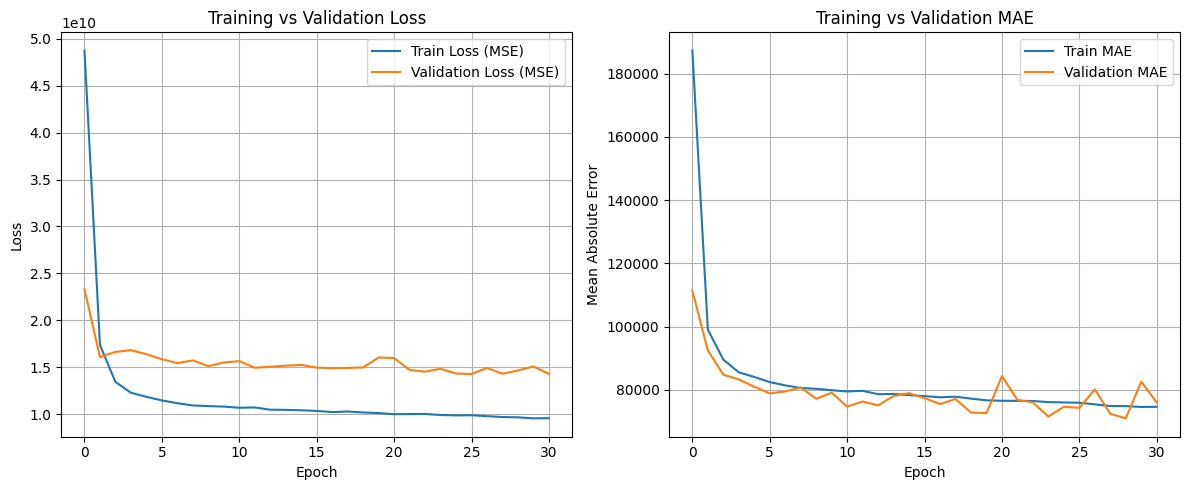

In [73]:
# Plot Loss (MSE)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Train Loss (MSE)')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['mae'], label='Train MAE')
plt.plot(history_cnn.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Training vs Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Predict

In [74]:
data_baru = {
    'longitude': -122.23,
    'latitude': 40.88,
    'housing_median_age': 41.0,
    'total_rooms': 882.0,
    'total_bedrooms': 129.0,
    'population': 352.0,
    'households': 136.0,
    'median_income': 8.3252,
    'ocean_proximity': 'NEAR BAY'
}
data_baru_df = pd.DataFrame([data_baru])

encoded_baru = ohe.transform(data_baru_df[["ocean_proximity"]])
encoded_baru_df = pd.DataFrame(encoded_baru, columns=ohe.get_feature_names_out(["ocean_proximity"]))

# 4. Gabungkan semua fitur
data_baru_numeric = data_baru_df.drop("ocean_proximity", axis=1)
data_baru_final = pd.concat([data_baru_numeric, encoded_baru_df], axis=1)

# 5. Standarisasi fitur numerik
data_baru_scaled = scaler.transform(data_baru_final)

# 6. Prediksi harga
prediksi_harga = cnn_model.predict(data_baru_scaled)
print(f"Prediksi harga rumah: ${prediksi_harga[0][0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Prediksi harga rumah: $233,825.48
